### Segmentation Using U-Net

#### Importing the neccessary libraries

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

#### Implementing a functions to display the tensors

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    
    #image_shifted = (image_tensor + 1) / 2
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Contracting Path

In [3]:
class ContractingBlock(nn.Module):
    
    def __init__(self, input_channels):
        
        super(ContractingBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, input_channels*2, kernel_size=3)
        self.conv2 = nn.Conv2d(input_channels*2, input_channels*2, kernel_size=3)
        self.activation = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        
        return x
    
    def get_self(self):
        
        return self

In [4]:
#UNIT TEST
def test_contracting_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ContractingBlock(test_channels)
    test_in = torch.randn(test_samples, test_channels, test_size, test_size)
    test_out_conv1 = test_block.conv1(test_in)
    # Make sure that the first convolution has the right shape
    assert tuple(test_out_conv1.shape) == (test_samples, test_channels * 2, test_size - 2, test_size - 2)
    # Make sure that the right activation is used
    assert torch.all(test_block.activation(test_out_conv1) >= 0)
    assert torch.max(test_block.activation(test_out_conv1)) >= 1
    test_out_conv2 = test_block.conv2(test_out_conv1)
    # Make sure that the second convolution has the right shape
    assert tuple(test_out_conv2.shape) == (test_samples, test_channels * 2, test_size - 4, test_size - 4)
    test_out = test_block(test_in)
    # Make sure that the pooling has the right shape
    assert tuple(test_out.shape) == (test_samples, test_channels * 2, test_size // 2 - 2, test_size // 2 - 2)

test_contracting_block()
test_contracting_block(10, 9, 8)
print("Success!")

Success!


C:\Users\DESKTOP\anaconda3\envs\specter\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#### Expanding Block

In [5]:
def crop(image, new_shape):
    
    '''
    Function for cropping an image tensor: Given an image tensor and the new shape,
    crops to the center pixels (assumes that the input's size and the new size are
    even numbers).
    Parameters:
        image: image tensor of shape (batch size, channels, height, width)
        new_shape: a torch.Size object with the shape you want x to have
    '''
    middle_height = image.shape[2] // 2
    middle_width = image.shape[3] // 2
    starting_height = middle_height - new_shape[2] // 2
    final_height = starting_height + new_shape[2]
    starting_width = middle_width - new_shape[3] // 2
    final_width = starting_width + new_shape[3]
    
    cropped_image = image[:, :, starting_height: final_height, starting_width: final_width]
    
    return cropped_image

In [6]:
#UNIT TEST
def test_expanding_block_crop(test_samples=100, test_channels=10, test_size=100):
    # Make sure that the crop function is the right shape
    skip_con_x = torch.randn(test_samples, test_channels, test_size + 6, test_size + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    cropped = crop(skip_con_x, x.shape)
    assert tuple(cropped.shape) == (test_samples, test_channels, test_size, test_size)

    # Make sure that the crop function takes the right area
    test_meshgrid = torch.meshgrid([torch.arange(0, test_size), torch.arange(0, test_size)])
    test_meshgrid = test_meshgrid[0] + test_meshgrid[1]
    test_meshgrid = test_meshgrid[None, None, :, :].float()
    cropped = crop(test_meshgrid, torch.Size([1, 1, test_size // 2, test_size // 2]))
    assert cropped.max() == (test_size - 1) * 2 - test_size // 2
    assert cropped.min() == test_size // 2
    assert cropped.mean() == test_size - 1

In [7]:
class ExpandingBlock(nn.Module):
    
    def __init__(self, input_channels):
        
        super(ExpandingBlock, self).__init__()
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=2)
        self.conv2 = nn.Conv2d(input_channels, input_channels // 2, kernel_size=3)
        self.conv3 = nn.Conv2d(input_channels // 2, input_channels // 2, kernel_size=3)
        self.activation = nn.ReLU()
        
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        skip_con_x = crop(skip_con_x, x.shape)
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x
    
    # Required for grading
    def get_self(self):
        return self

In [8]:
#UNIT TEST
def test_expanding_block(test_samples=100, test_channels=10, test_size=50):
    test_block = ExpandingBlock(test_channels)
    skip_con_x = torch.randn(test_samples, test_channels // 2, test_size * 2 + 6, test_size * 2 + 6)
    x = torch.randn(test_samples, test_channels, test_size, test_size)
    x = test_block.upsample(x)
    x = test_block.conv1(x)
    # Make sure that the first convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 1, test_size * 2 - 1)
    orginal_x = crop(skip_con_x, x.shape)
    x = torch.cat([x, orginal_x], axis=1)
    x = test_block.conv2(x)
    # Make sure that the second convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 3, test_size * 2 - 3)
    x = test_block.conv3(x)
    # Make sure that the final convolution produces the right shape
    assert tuple(x.shape) == (test_samples, test_channels // 2,  test_size * 2 - 5, test_size * 2 - 5)
    x = test_block.activation(x)

test_expanding_block_crop()
test_expanding_block()
print("Success!")

Success!


#### Final Layer

In [9]:
class FeatureMapBlock(nn.Module):
    
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    
    def __init__(self, input_channels, output_channels):
        
        super(FeatureMapBlock, self).__init__()
        
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        
    def forward(self, x):
        
        x = self.conv(x)
        return x

In [10]:
# UNIT TEST
assert tuple(FeatureMapBlock(10, 60)(torch.randn(1, 10, 10, 10)).shape) == (1, 60, 10, 10)
print("Success!")

Success!


### U-Net

In [11]:
class UNet(nn.Module):
    
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        
        super(UNet, self).__init__()
        
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)
        x2 = self.contract2(x1)
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)
        
        return xn

In [12]:
#UNIT TEST
test_unet = UNet(1, 3)
assert tuple(test_unet(torch.randn(1, 1, 256, 256)).shape) == (1, 3, 117, 117)
print("Success!")

Success!


### Training

In [13]:
import torch.nn.functional as F

criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
input_dim = 1
label_dim = 1
display_step = 20
batch_size = 1
lr = 0.0002
initial_shape = 512
target_shape = 373
device = 'cuda'

In [14]:
from skimage import io
import numpy as np

volumes = torch.Tensor(io.imread('train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread('train-labels.tif', plugin='pil'))[:, None, :, :] / 255
labels = crop(labels, torch.Size([len(labels), 1, target_shape, target_shape]))
dataset = torch.utils.data.TensorDataset(volumes, labels)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 : Step 0: U-Net Loss: 0.6763284206390381


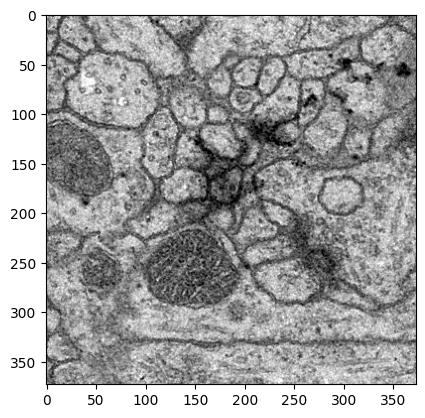

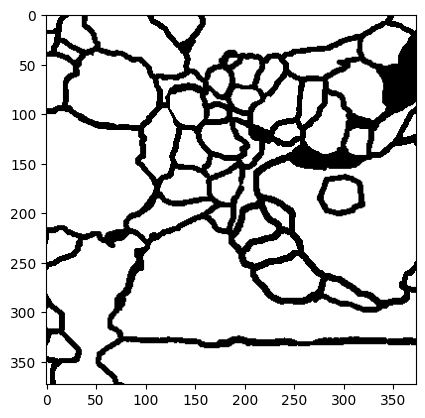

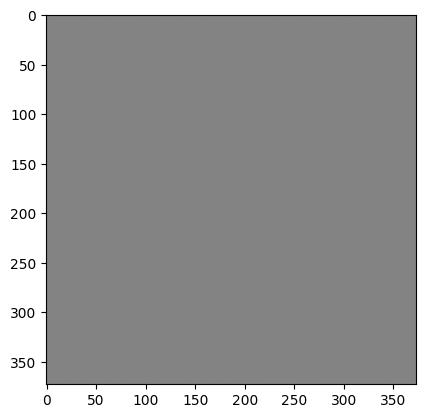

RuntimeError: CUDA out of memory. Tried to allocate 70.00 MiB (GPU 0; 3.00 GiB total capacity; 1.97 GiB already allocated; 0 bytes free; 1.99 GiB reserved in total by PyTorch)

In [15]:
import gc

def train():
    
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True
    )
    unet = UNet(input_dim, label_dim).to(device)
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    cur_step = 0
    
    for epoch in range(n_epochs):
        
        for real, labels in tqdm(dataloader):
            
            cur_batch_size = len(real)
            
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device)
            
            # Update U-Net
            unet_opt.zero_grad()
            pred = unet(real)
            unet_loss = criterion(pred, labels)
            unet_loss.backward() # Accumulates gradient for each parameter
            unet_opt.step()  # Performs a parameter update based on the current gradient
            unet_opt.zero_grad()

            
            if cur_step % display_step == 0:
                
                print(f"Epoch {epoch} : Step {cur_step}: U-Net Loss: {unet_loss.item()}")
                show_tensor_images(
                    crop(real, torch.Size([len(real), 1, target_shape, target_shape])),
                    size=(input_dim, target_shape, target_shape)
                )
                show_tensor_images(labels, size=(label_dim, target_shape, target_shape))
                show_tensor_images(torch.sigmoid(pred), size=(label_dim, target_shape, target_shape))
            
            cur_step += 1
            
            del real, labels
            gc.collect()

train()

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
import gc
del real, labels
gc.collect()